## Gradient Boosting Machine

This is an attempt to implement toy Gradient Boosting Machine from scratch. Algorithm used is:
<img src="../Algorithm.jpg" />
This has been taken from the book Elements of Statistical Learning, Second Edition by Tibshirani, Hastie and Friedman

In [2]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_gaussian_quantiles
import copy
import numpy as np
%matplotlib inline
import random
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingClassifier
warnings.filterwarnings("ignore")
import csv
import math

In [3]:
def Entropy(Data):
    
    if len(np.unique(Data[:,4]))==2:
        entropy=-1*((1/sum(Data[:,3]))*sum(Data[:,3][np.where(Data[:,4]==1)])*
                np.log2(1/sum(Data[:,3])*sum(Data[:,3][np.where(Data[:,4]==1)]))
                +
                (1/sum(Data[:,3]))*sum(Data[:,3][np.where(Data[:,4]==-1)])*
                np.log2((1/sum(Data[:,3]))*sum(Data[:,3][np.where(Data[:,4]==-1)])))
    else:
        return 0
    
    return entropy
    

In [4]:
def gini(Data):
    
    if len(np.unique(Data[:,4]))==2:
        gini=1-((1/sum(Data[:,3]))*sum(Data[:,3][np.where(Data[:,4]==1)]))**2-((1/sum(Data[:,3]))*sum(Data[:,3][np.where(Data[:,4]==-1)]))**2
    else:
        return 0
    
    return gini
    

In [5]:
def InformationGain(Threshold,Data,Feature):
    
    DataL=Data[np.where(Data[:,Feature]>=Threshold)]
    DataR=Data[np.where(Data[:,Feature]<Threshold)]
    
    H_all = gini(Data)
    
    H_L = gini(DataL)
    
    H_R = gini(DataR)

    return H_all-(sum(DataL[:,3])/sum(Data[:,3]))*H_L - (sum(DataR[:,3])/sum(Data[:,3]))*H_R

In [6]:
def GetBestFeature(Data):
        
    Feature1 = []
    
    Feature2 = []
    
    Feature1ThresholdList=np.sort(Data[:,0])
    Feature2ThresholdList=np.sort(Data[:,1])
    
    for k in range(1,len(Data)-1):
            
        InfoGainFeat_1 = InformationGain((Feature1ThresholdList[k-1]+Feature1ThresholdList[k])/2,Data,0)
        InfoGainFeat_2  = InformationGain((Feature2ThresholdList[k-1]+Feature2ThresholdList[k])/2,Data,1)
        
        Feature1.append([InfoGainFeat_1,(Feature1ThresholdList[k-1]+Feature1ThresholdList[k])/2])
        Feature2.append([InfoGainFeat_2,(Feature2ThresholdList[k-1]+Feature2ThresholdList[k])/2])
       
    Feature1 = np.vstack(Feature1)
    Feature2 = np.vstack(Feature2)
    
    BestThresholdFeat_1, ThresholdIndex1 = max(Feature1[:,0]), np.argmax(Feature1[:,0])
    BestThresholdFeat_2, ThresholdIndex2 = max(Feature2[:,0]), np.argmax(Feature2[:,0])
    
    if BestThresholdFeat_1==BestThresholdFeat_2:
        if np.random.choice(2,1)[0]==0:
            return 0,Feature1[ThresholdIndex1,1]   
        else:
            return 1,Feature2[ThresholdIndex2,1]
    elif BestThresholdFeat_1 > BestThresholdFeat_2:
        return 0, Feature1[ThresholdIndex1,1]
    else:
        return 1, Feature2[ThresholdIndex2,1]
    

In [7]:
def CreateTree(BestFeature, SplittingThreshold, FullData):
    
    LeftChildData = FullData[np.where(FullData[:,BestFeature]>=SplittingThreshold)]
    RightChildData = FullData[np.where(FullData[:,BestFeature]<SplittingThreshold)]
    
    PositiveClassCount = sum(LeftChildData[:,3][np.where(LeftChildData[:,4]==1)])
    NegativeClassCount = sum(LeftChildData[:,3][np.where(LeftChildData[:,4]==-1)])
    
    if PositiveClassCount>=NegativeClassCount:
        LeftChildPred = 1.0
    else:
        LeftChildPred = -1.0
    
    PositiveClassCount = sum(RightChildData[:,3][np.where(RightChildData[:,4]==1)])
    NegativeClassCount = sum(RightChildData[:,3][np.where(RightChildData[:,4]==-1)])
    
    if PositiveClassCount>=NegativeClassCount:
        RightChildPred =  1.0
    else:
        RightChildPred = -1.0
    
    return {'Feature':BestFeature, 'Split':SplittingThreshold, 'LeftChildPred':LeftChildPred, 'RightChildPred':RightChildPred}

In [8]:
def classify(Data,Tree):
    
    if Data[Tree['Feature']]>=Tree['Split']:
        return Tree['LeftChildPred']
    else:
        return Tree['RightChildPred']

In [9]:
def _DecisionTreeClassifier(Data):
    
    BestFeature, SplittingThreshold = GetBestFeature(Data)
    
    Tree = CreateTree(BestFeature, SplittingThreshold, Data)
    
    return Tree

In [15]:
def GBM(DataInput,depth,maxdepth,M,SamplePercent):
    
    # create list of learners
    LearnerList=[]
    
    AlphaList = []
    
    Data=copy.deepcopy(DataInput)
    
    Data=np.c_[Data,np.array([1/(len(DataInput))]*(len(Data))),Data[:,2]]
    
    for m in range(0,M):        
    
        #Train a weak learner on the weigthed dataset
        Learner = _DecisionTreeClassifier(Data)
        
        #Generate prediction for each data point
        Prediction = []
        for row in Data:
            Prediction.append(classify(row,Learner))
        
        Prediction = np.array(Prediction)

        #Sum of weights of correctly classified points
        epsilon1 = sum(Data[:,3][np.where(Data[:,4]==Prediction)])
        
        #Sum of weights of incorrectly classified points
        epsilon2 = sum(Data[:,3][np.where(Data[:,4]!=Prediction)])
        
        #Calculate alpha:
        #Since the one-dimensional optimization problem to find alpha
        #has a closed form solution, we can obtain the exact solution.
        #In any case, we can always approximate the solution by taking 
        #single step of Newton-Raphson method, as suggested in FHT00
        
        #alpha = (1/2)*np.log((epsilon1)/epsilon2)  -- Exact solution
        #alpha = epsilon1-epsilon2  -- N-R approx solution
        
        alpha=epsilon1-epsilon2
        
        #Update weights for every data point
        for i in range(0,len(Data)):
            if Data[i,4]!=Prediction[i]:
                Data[i,3]=Data[i,3]*np.exp(-1*alpha*Data[i,4]*Prediction[i])
        
        Data[:,3]=Data[:,3]/np.sum(Data[:,3])
        
        # Append the learner at this stage to the learner list
        AlphaList.append(alpha)
        LearnerList.append(Learner)
        
    return LearnerList, AlphaList

In [11]:
def plot(data,alphas,learners):
    xx = np.linspace(min(data[:,0])-0.1, max(data[:,0])+0.1, 30)
    yy = np.linspace(min(data[:,1])-0.1, max(data[:,1])+0.1, 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.array(np.vstack([XX.ravel(), YY.ravel()]).T)
    pred=[0]*len(xy)
    pred=np.array(pred)
    Threshold=[0]*len(xy)
    
    
    
    for i in range(0,len(xy)):
        for tree_model, _alpha in zip(learners, alphas):

            Threshold[i]=Threshold[i]+_alpha*classify(xy[i,:].reshape(1,-1)[0],tree_model)

        if Threshold[i]>=0:
            pred[i]=1
        else:
            pred[i]=0
    
    Z=pred.reshape(XX.shape)
    f = plt.figure(figsize=(14,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
    plt.subplot(122)
    ax2.contourf(XX, YY, Z,cmap=plt.cm.coolwarm,alpha=0.9)
    ax2.scatter(data[:,0], data[:,1],c=data[:,2],s=50,edgecolors='black')
    plt.show()

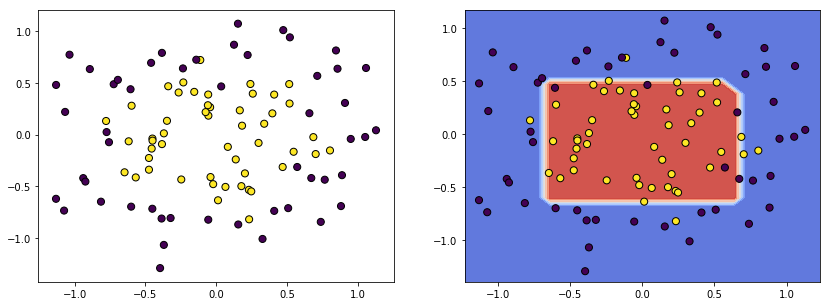

In [16]:
X,Y=make_circles(noise=0.2, factor=0.5, random_state=1)
data=np.append(X,Y.reshape(-1,1),axis=1)
data[:,2][np.where(data[:,2]==0.0)]=-1
M=50
learners, alpha=GBM(np.copy(data),0,1,M,100)
plot(data, alpha,learners)

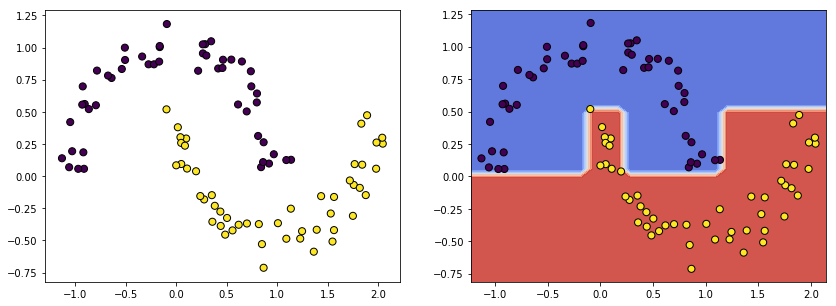

In [17]:
X,Y=make_moons(n_samples=100, shuffle=True, noise=0.1, random_state=100)
data=np.append(X,Y.reshape(-1,1),axis=1)
data[:,2][np.where(data[:,2]==0.0)]=-1
M=50
learners, alpha=GBM(copy.deepcopy(data),0,1,M,100)
plot(data, alpha, learners)

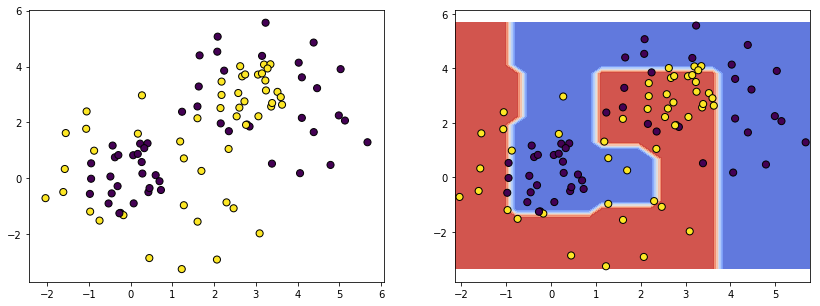

In [18]:
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=50, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=50, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
Y = np.concatenate((y1, - y2 + 1))

data=np.append(X,Y.reshape(-1,1),axis=1)
data[:,2][np.where(data[:,2]==0.0)]=-1
M=100
learners, alpha=GBM(copy.deepcopy(data),0,1,M,100)
plot(data, alpha, learners)

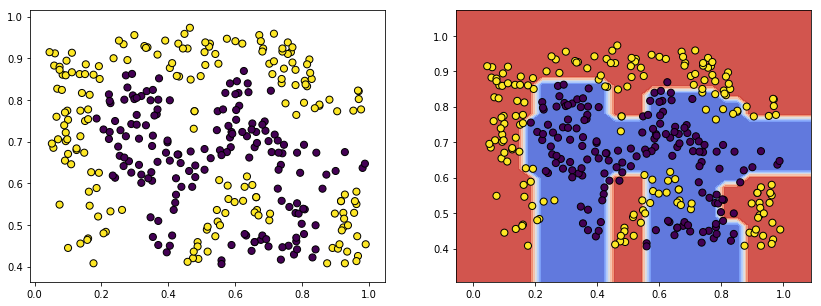

In [197]:
data_2=[]
with open("ex8a.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        data_2.append(row)
    f.close()
    
data_2=np.array(np.vstack(data_2))
data=np.ndarray.astype(data_2,float)

RandomSelectedAxes=np.random.choice(data.shape[0], int((len(data))*(40/100)), replace=False)
data=data[RandomSelectedAxes,:]
data[:,2][np.where(data[:,2]==0.0)]=-1

M=100
learners, alpha=GBM(copy.deepcopy(data),0,1,M,100)
plot(data, alpha, learners)